# ANOMALY/OUTLIER DETECTION USING ONE-CLASS SVM IN PYTHON

The goal of anomaly detection is to identify cases that are unusual within data that is seemingly homogeneous. Anomaly detection is an important tool for detecting fraud, network intrusion, and other rare events that may have great significance but are hard to find.

Outliers are cases that are unusual because they fall outside the distribution that is considered normal for the data. The distance from the center of a normal distribution indicates how typical a given point is with respect to the distribution of the data. Each case can be ranked according to the probability that it is either typical or atypical.

Anomaly detection is a form of classification and is implemented as one-class classification, because only one class is represented in the training data. An anomaly detection model predicts whether a data point is typical for a given distribution or not. An atypical data point can be either an outlier or an example of a previously unseen class. 

The dataset is taken from : http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between 'bad' connections, called intrusions or attacks, and 'good' normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

We're using the 10 percent set containing a little under half a million datapoints and 3 (of 41) features (columns) that are relevant for HTTP requests. Lets begin by importing the libraries and the dataset. 

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 

Now read the dataset from the url and give it random shuffle

In [2]:
data = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz',header =None)

In [3]:
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
1,0,tcp,http,SF,313,2439,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,147,0,0,0,0,...,225,0.88,0.01,0.0,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,REJ,0,0,0,0,0,0,...,44,1.00,0.00,1.0,0.2,0.0,0.0,1.0,1.0,normal.
4,0,tcp,private,S0,0,0,0,0,0,0,...,20,0.08,0.06,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
5,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
6,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
7,0,tcp,http,SF,220,654,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.
8,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
9,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.


We need the data with the columns 'duration', 'service', 'src_bytes', 'dst_bytes', 'logged_in' and the 'label'.

In [4]:
X = data.iloc[:,[0,2,4,5,11,41]]
X.columns = ["duration","service","src_bytes","dst_bytes","logged_in","label"]
X.head(10)

,duration,service,src_bytes,dst_bytes,logged_in,label
0,0,ecr_i,520,0,0,smurf.
1,0,http,313,2439,1,normal.
2,0,private,105,147,0,normal.
3,0,http,0,0,0,normal.
4,0,private,0,0,0,neptune.
5,0,ecr_i,1032,0,0,smurf.
6,0,ecr_i,1032,0,0,smurf.
7,0,http,220,654,1,normal.
8,0,ecr_i,520,0,0,smurf.
9,0,ecr_i,1032,0,0,smurf.


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 6 columns):
duration     494021 non-null int64
service      494021 non-null object
src_bytes    494021 non-null int64
dst_bytes    494021 non-null int64
logged_in    494021 non-null int64
label        494021 non-null object
dtypes: int64(4), object(2)
memory usage: 22.6+ MB


We are considering data that are relevant for HTTP requests. So we need to extract just the logged-in HTTP accesses from the data. i.e. where 'service' = HTTP and 'logged_in' =1

In [6]:
X = X[X['service'] == "http"]  
X = X[X["logged_in"] == 1]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58725 entries, 1 to 494005
Data columns (total 6 columns):
duration     58725 non-null int64
service      58725 non-null object
src_bytes    58725 non-null int64
dst_bytes    58725 non-null int64
logged_in    58725 non-null int64
label        58725 non-null object
dtypes: int64(4), object(2)
memory usage: 3.1+ MB


Let's take a look at the types of attack labels are present in the data.

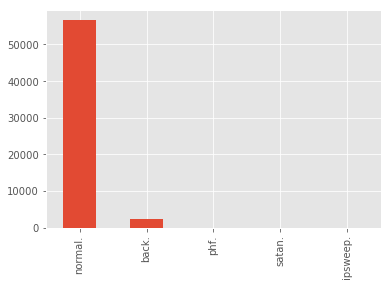

In [7]:
X.label.value_counts().plot(kind='bar') 

Did you see the outliers?

## Data Preprocessing

Lets now normalise the data - this leads to better accuracy and reduces numerical instability in the SVM implementation

In [8]:
X["duration"] = np.log((X["duration"] + 0.1).astype(float))  
X["src_bytes"] = np.log((X["src_bytes"] + 0.1).astype(float))  
X["dst_bytes"] = np.log((X["dst_bytes"] + 0.1).astype(float))  

Later, we're going to use scikit-learn's OneClassSVM predict function to generate output. This returns +1 or -1 to indicate whether the data is an "inlier" or "outlier" respectively. To make comparison easier later we'll replace our data's label with a matching +1 or -1 value. This also transforms our data from multi-class (multiple different labels) to one-class (boolean label), which is a prerequisite for using a one-class SVM.

In [9]:
X.loc[X['label'] == "normal.", "attack"] = 1  
X.loc[X['label'] != "normal.", "attack"] = -1

Now grab out the attack value as the target, y,  for training and testing

In [10]:
y = X['attack']

Find the proportion of outliers we expect (aka where attack == -1). Because target is a series, we just compare against itself rather than a column.

In [11]:
outliers = y[y == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", outliers.shape[0]/y.shape[0])

outliers.shape (2209,)
outlier fraction 0.03761600681140911


Drop label columns from the dataframe. we're doing this so we can do unsupervised training with unlabelled data. we've already copied the labelout into the y series so we can compare against it later.

In [12]:
X.drop(["label", "attack"], axis=1, inplace=True)

For analysis we do not need columns 'service' and 'logged_in', so lets drop them

In [13]:
X.drop(["service","logged_in"],axis =1,inplace= True)

## Splitting to training and test sets

In [14]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)  
X_train.shape 

(46980, 3)

Set nu (which should be the proportion of outliers in our dataset)

In [15]:
nu = outliers.shape[0] / y.shape[0]  
print("nu", nu)

nu 0.03761600681140911


Observe that the percentage of anomalies/outliers in the label is 3 %

## Building the classifier

In [16]:
from sklearn import svm
classifier = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  
classifier.fit(X_train) 

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.03761600681140911, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

Now evaluate the model error parameters

In [17]:
from sklearn import metrics  
preds_train = classifier.predict(X_train) 
print("accuracy: ", metrics.accuracy_score(y_train, preds_train))  
print("precision: ", metrics.precision_score(y_train, preds_train))  
print("recall: ", metrics.recall_score(y_train, preds_train))  
print("f1: ", metrics.f1_score(y_train, preds_train))  
print("area under curve (auc): ", metrics.roc_auc_score(y_train, preds_train))  

accuracy:  0.942358450404
precision:  0.963162936515
recall:  0.97754993813
f1:  0.970303110058
area under curve (auc):  0.498055711524


Observe that the oneclassSVM classifier has a very good accuracy on the training set. Lets do the same for test set.

In [18]:
preds_test = classifier.predict(X_test)  

print("accuracy: ", metrics.accuracy_score(y_test, preds_test))  
print("precision: ", metrics.precision_score(y_test, preds_test))  
print("recall: ", metrics.recall_score(y_test, preds_test))  
print("f1: ", metrics.f1_score(y_test, preds_test))  
print("area under curve (auc): ", metrics.roc_auc_score(y_test, preds_test))  

accuracy:  0.939719029374
precision:  0.958942240779
recall:  0.979040852575
f1:  0.968887326419
area under curve (auc):  0.502922488143


Accuracy holds good for test set too. 94 %

In [19]:
preds_train.size

46980

In [20]:
n_outliers_train = preds_train[preds_train == -1].size
n_outliers_train

1048

From above we see that out of the total 46980 predictions, 1048 have been classified as outliers/intrusions in the training set

In [21]:
preds_test.size

11745

In [22]:
n_error_test = preds_test[preds_test == -1].size
n_error_test

249

For the test set we see that 249 out of 11745 has been classified as anomalies by the classifier with an accuracy of 94 %

# Concluding Remarks

1. Out of the total 46980 predictions, 1048 have been classified as outliers/intrusions in the training set with an accuracy of 94.2 %
2. For the test set we see that 249 out of 11745 has been classified as anomalies by the classifier with an accuracy of 94 %